# Проект "Предсказание вероятности подключения услуги"

## Постановка задачи

#### Задача

Требуется на основании имеющихся данных об абонентах Мегафон построить алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

#### Целевая переменная

**target** - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 

#### Метрика качества

F1-score (sklearn.metrics.f1_score)

#### Требования к решению

*Целевая метрика*

* Метрика оценивается невзвешенным образом, , как например делает функция sklearn.metrics.f1_score(…, average=’macro’)

*Решение должно содержать*

1.	Работающая модель в формате pickle, которая принимает файл data_test.csv из корневой папки и записывает в эту же папку файл answers_test.csv. В этом файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно записать как вероятность подключения услуги.
2.	Тетрадка Jupyter Notebook с кодом модели. 
3.	Презентация в формате .pdf, в которой необходимо отразить:

   * Информация о модели, ее параметрах, особенностях и основных результатах.
   * Обоснование выбора модели и ее сравнение с альтернативами.
   * Принцип составления индивидуальных предложений для выбранных абонентов.

   Рекомендуемое количество слайдов – 5 – 10.

Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и резюме необходимо прикрепить ко второму уроку “курсовой проект”.

## Решение

### 1. Обзор данных

В качестве исходных данных представлена информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.

Отдельным набором данных является нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.

Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц. 

Итого, в качестве входных данных представлены:
* **data_train.csv**: 
    * id, 
    * vas_id, 
    * buy_time, 
    * target
* **features.csv.zip**: 
    * id, 
    * ..feature_list..

И тестовый набор:
* **data_test.csv**: 
    * id, 
    * vas_id, 
    * buy_time

**Описание датасета**
* **id** - идентификатор абонента
* **vas_id** - подключаемая услуга
* **buy_time** - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
* **target** - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно.

#### Подключение библиотек и скриптов

In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin

from catboost import CatBoostClassifier

Вспомогательные функции

In [2]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    """
    График ROC-кривой
    """
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")
    
def plot_precision_recall_curve(precision, recall, model_name="", color=None):
    """
    График Precision-Recall кривой
    """    
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

#### Загрузка данных

Загрузим датасеты, созданные на этапе предподготовки. 

В качестве предподготовки было проведено слияние набора признаков, характеризующих профиль потребления абонента, с тренировочным датасетом, тестовым датасетом. Новые датасеты были сохранены в файлы:
* data_feat_train.pkl - новый тренировчный датасет
* data_feat_test.pkl - новый тестовый датасет

In [3]:
train_path = 'data_feat_train.pkl'
test_path = 'data_feat_test.pkl'

In [4]:
train_df = pd.read_pickle(train_path)

#### Получение информации о данных

In [5]:
train_df.shape

(831653, 258)

In [6]:
train_df.head()

,id,vas_id,buy_time_vas,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,time_delta
0,540968.0,8.0,1.537132e+09,0.0,-31.559971,327.360901,-45.500786,274.753204,-50.918247,253.648209,49.15382,195.883896,-1.835267,-12.831245,-2.736081,56.284081,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,54.495834,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,2.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,62.580612,-0.065583,-0.700765,-192.026962,239.787094,-1005.230652,1245.017822,-89.504288,-119.724358,-3.512019,33.247475,-36.759495,-7.896282,-7.997875,-10.697456,-28.551693,-17.130283,-16.088985,-26.171711,-5.331295,1.041298,-3.745251,-1.671324,-0.001656,9.318354,15.117334,0.174766,-0.108162,0.028356,-0.017576,-0.165662,-0.028454,-0.044465,-0.301128,-0.554677,-0.036834,-0.130031,-2.783592,-2.60662,-5.390212,-4.022547,0.0,-2.824022,-10.706438,-1.2015,-0.998268,-0.203232,0.0,-0.248755,-0.222852,-0.134088,0.0,-0.030537,-0.125866,-0.096986,-0.679774,-0.626985,-0.691912,-0.506613,-0.185299,-0.598716,-0.000115,-0.250188,-0.348913,-0.828382,-42.275913,-3.950157,-0.253037,-0.318148,-2.29064,-3.447583,-0.040043,-9.408469,-0.212137,-11.955315,-1.019293,-1.473446,0.37916,-1006.426575,1242.881104,0.03201,0.196143,236.454514,848.953552,-0.343415,-0.08972,-0.278878,-0.433135,-0.024048,-89.211945,-119.674408,-208.886353,0.031923,-0.030451,0.104871,1.381836,5.318359,1.426717,-0.468443,-0.017283,-190.670380,5.856777,7.27741,2.174027,5.064012,0.0,-1.276187,-0.020137,-0.042636,-11.480350,-59.370804,34.036369,-17.888325,0.138539,-0.317164,-0.007024,-0.143269,-14.417671,-0.212646,-0.019562,-0.000044,-0.000379,-2.548856,-0.261309,-0.536315,-0.061481,-0.152157,-0.002595,1.321786,-0.014542,-0.009508,-8.183167,35.756905,-14.320085,-40.801491,-5.961228,33.187763,-12.614497,-26.671719,-0.028857,-0.063214,-0.019198,-0.033778,-0.003149,-0.005184,-0.001431,-0.00189,-1.257363,-2.793638,-1.932758,-5.008096,-15.978121,-36.800720,-9.354808,-25.320370,-0.034569,-0.163184,-109.036400,0.533317,-1.929048,-0.623737,-0.228106,-0.251959,-0.000567,0.566264,-0.000708,-0.02921,-0.104665,-0.001358,0.0,0.039208,0.665644,-0.008999,-11953.712891,-45175.257812,-0.622901,-30.716053,-61790.156250,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,969818880.0,-49.224079,-4.405604e+08,-120441800.0,-8.634002,-1.465191,-33.30238,810.871033,270.227509,-0.364694,-0.133771,-0.209468,269.643494,-109.884567,364.308990,41.631718,938.889282,-108.409744,-504.437317,-53.617977,-12.295406,-845.37384,-613.770813,-20.996269,-37.630447,-28.747725,4.167111,7.305572,-12.175933,21.543859,0.0,4838400.0
1,1454121.0,4.0,1.531688e+09,0.0,547.270020,238.430893,533.329224,274.803192,527.911743,253.698212,-16.08618,-65.076096,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,577.880859,566.551880,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.659389,-0.065583,-0.700765,-192.026962,-2764.330078,-1102.746338,-1661.5

**Описание датасета**
* **id** - идентификатор абонента
* **vas_id** - подключаемая услуга
* **buy_time_vas** - время покупки
* 253 нормализованных анонимизированных признаков, характеризующих профиль потребления абонента
* **time_delta** - отражает разницу во времени между временными штампами отклика на услугу (buy_time_vas) и фиксации записи по признакам профиля потребления ('buy_time' в наборе признаков, характиризующих профиль потребления абонента)
* **target** - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно.

### 2. Анализ признаков

#### target

Целевая переменная, определяет отклик клиента на услугу.

* 0 - клиент отказался от услуги
* 1 - клиент подключил услугу

Рассмотрим распределение переменной в обучающей выборке:

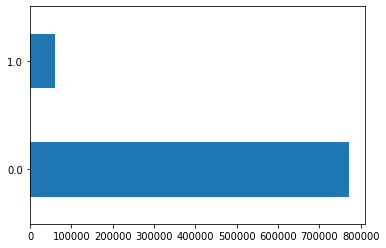

In [7]:
train_df['target'].value_counts().plot(kind='barh')
plt.show()

Наблюдается сильная несбалансированность классов. Это необходимо будет учесть при построении моделей.

#### vas_id

Идентификатор услуги. Рассмотрим распределение признака.

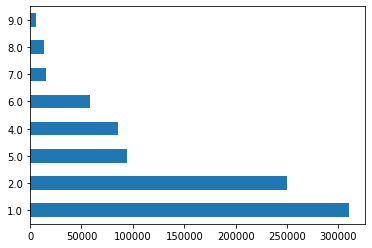

In [8]:
train_df['vas_id'].value_counts().plot(kind='barh')
plt.show()

Будем использовать этот признак в качестве категориального.

#### id

Использование id в модели нецелесообразно. id - уникальный идентификатор клиента: как число исползовать нельзя, а как категорию практически невозможно, так как появляются новые клиенты. Поэтому id не будем использовать в обучающей выборке.

#### buy_time_vas

In [9]:
date = pd.to_datetime(train_df['buy_time_vas'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Europe/Moscow')
date.sample(5)

668938   2018-07-23 00:00:48+03:00
108890   2018-10-01 00:00:48+03:00
551266   2018-07-23 00:00:48+03:00
191835   2018-09-24 00:00:48+03:00
731059   2018-11-26 00:00:48+03:00
Name: buy_time_vas, dtype: datetime64[ns, Europe/Moscow]

Присутствует только информация по дате. Рассмотрим количество уникальных составляющих даты по всему признаку:

In [10]:
date_features = pd.DataFrame()
date_features['month'] = date.dt.month
date_features['day'] = date.dt.day
date_features['dayofyear'] = date.dt.dayofyear
date_features['dayofweek'] = date.dt.dayofweek
date_features['weekofyear'] = date.dt.weekofyear
date_features.nunique()

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


month          6
day           22
dayofyear     26
dayofweek      1
weekofyear    26
dtype: int64

* Имеются наблюдения за 6 месяцев.
* Все наблюдения относятся к одному дню недели, соответственно, данные day, dayofyear не несут никакой полезной информации.
* Признаки month и weekofyear по логике сильно коррелированы.

Рассмотрим влияние номера недели в году на относительную частоту положительного отклика клиентов на услугу.

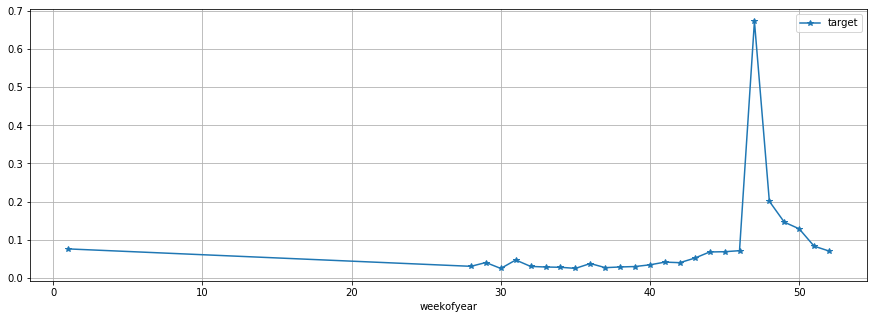

In [11]:
week_target = pd.concat([train_df['target'], date, date_features['weekofyear']], axis=1).sort_values('buy_time_vas')
week_target.groupby('weekofyear').mean().plot(style='-*', figsize=(15,5), grid=True)
plt.show()

Наблюдения weekofyear, имеющие значение 1, на самом деле относятся к самому концу года. Дело в том, что это дата 31 декабря 2018 года. И это понедельник - поэтому алгоритм определяет эту дату как первую неделю 2019 года. Но это не имеет значения.

На графике наблюдается аномальный скачок частоты положительных откликов на 47 неделе. Это 19-25 ноября 2018 г., обычная рабочая неделя. Возможно, данная аномалия может объясняться запуском в этот период особых маркетинговых акций или рекламных кампаний, так как рост скачка резкий, а спад чуть медленнее, инертнее. В любом случае, такие аномалии будут только ухудшать модель, поэтому не будем использовать временные данные buy_time_vas в обучении.

#### time_delta

Значения в секундах. Трансформируем данный признак в диапазоне значений от 0 до 1 и применим экспоненту от отрицательного значения. Чем больше временная разница, тем меньше вес. В конце проверим значения на пропуски.

In [12]:
w_sc = StandardScaler().fit_transform(train_df['time_delta'].values.reshape(-1,1))
w = 1 / (1 + np.exp(w_sc))

assert not np.isnan(w).any()

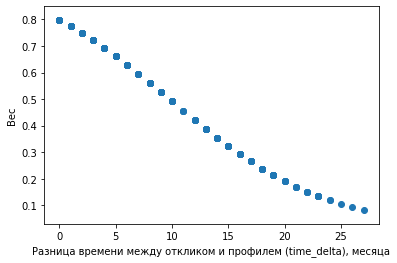

In [13]:
plt.scatter(train_df['time_delta'].values.reshape(-1,1)[:200]/(60*60*24*7),w[:200])
plt.xlabel('Разница времени между откликом и профилем (time_delta), месяца')
plt.ylabel('Вес')
plt.show()

In [14]:
train_df['time_delta'] = w

#### 253 нормализованных анонимизированных признаков, характеризующих профиль потребления абонента

Остальные признаки сложно разведать, поэтому будем применять селекцию признаков.

#### Выделение целевой переменнной

In [15]:
X = train_df.drop(['id','target','buy_time_vas'], axis=1)
y = train_df['target']

In [16]:
print("ID уникален? ", X.index.is_unique)
print("Есть ли дубли в строках?", X.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((X.isnull().sum() > 0).sum()/X.shape[1]*100))

ID уникален?  True
Есть ли дубли в строках? 681
Сколько процент признаков могут принимать null-значениями? 0%


### Определение типов признаков

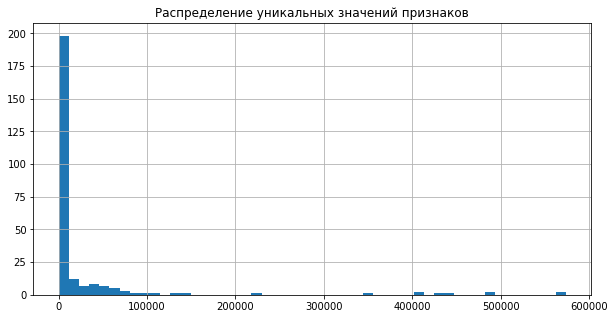

In [17]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))
plt.title("Распределение уникальных значений признаков");
X_nunique.hist(bins=50, figsize=(10, 5));

#### Всего признаков

In [18]:
f_all = set(X_nunique.index.tolist())
len(f_all)

255

#### Константные признаки

In [19]:
f_const = set(X_nunique[X_nunique == 1].index.tolist())
len(f_const)

5

#### Вещественные признаки

In [20]:
f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

248

In [21]:
f_other = f_all - (f_numeric | f_const )
len(f_other)

2

#### Категориальные признаки

Определим максимальное количество уникальных значений среди категориальных признаков = 20

In [22]:
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
f_categorical

{'vas_id'}

#### Прочие признаки

In [23]:
f_other = f_other - f_categorical
f_other

{'252'}

Рассмотрим признак '252'.

In [24]:
train_df['252'].value_counts()

0.0       620785
1.0       210825
2.0            5
3.0            3
10.0           3
8.0            3
5.0            2
4.0            2
7.0            2
11.0           2
13.0           2
283.0          1
223.0          1
42.0           1
44.0           1
299.0          1
1743.0         1
182.0          1
18.0           1
6.0            1
84.0           1
77.0           1
195.0          1
16.0           1
19.0           1
22.0           1
251.0          1
284.0          1
24.0           1
68.0           1
Name: 252, dtype: int64

Видно, что признак 252 практически бинарный. Удалим (=nan) все значения, кроме 0 и 1.

In [25]:
X.loc[X['252']>1,:] = X['252'].value_counts().argmax()

Отнесем признак '252' к категориальным

In [26]:
f_categorical = f_categorical | {'252'}
f_other = f_other - {'252'}
len(f_other)

0

Признак time_delta обозначим как весовой тип.

In [27]:
f_weight = {'time_delta'}
f_numeric = (f_numeric | f_other ) - f_weight

Проверка: не осталось ли пропущенных стобцов

In [28]:
assert(X_nunique.shape[0] == len(f_const) + len(f_numeric) + len(f_categorical) + len(f_weight))

#### Итог

In [29]:
print('f_all:', X.shape[1])
print()
print('f_const:', len(f_const))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))
print('f_weght:', len(f_weight))


f_ok = list(f_categorical | f_numeric | f_weight)
f_categorical, f_numeric, f_weight = list(f_categorical), list(f_numeric), list(f_weight)

f_all: 255

f_const: 5
f_categorical: 2
f_numeric: 247
f_weght: 1


### 3. Логистическая регрессия

#### 3.1 Разделяем на на тренировочную, валидационную выборки и веса

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

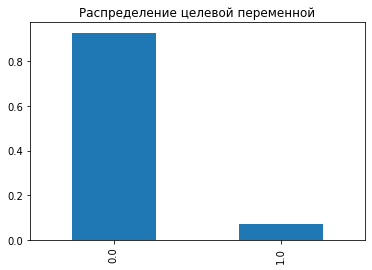

In [30]:
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Распределение целевой переменной');
y.value_counts()/y.shape

In [31]:
# Зафиксируем значение random_state для воспроизводимости результатов.
RANDOM_STATE = 42

X_train, X_valid, y_train, y_valid = train_test_split(X[f_ok], y, train_size=0.1, test_size=0.033, random_state=RANDOM_STATE)

columns_data = X_train.columns.drop(f_weight)

X_train_weight = X_train[f_weight].values.flatten()
X_valid_weight = X_valid[f_weight].values.flatten()

X_train = X_train.drop(f_weight, axis=1)
X_valid = X_valid.drop(f_weight, axis=1)

In [32]:
print("Train")
print(y_train.value_counts()/y_train.shape)
print()
print("Test")
print(y_valid.value_counts()/y_valid.shape)

Train
0.0    0.928095
1.0    0.071905
Name: target, dtype: float64

Test
0.0    0.925925
1.0    0.074075
Name: target, dtype: float64


#### 3.2 Пайплайн для обработки признаков

Логистическая регрессия требует отмасштабированные числовые признаки и перекодированные в числовые категориальные признаки.

In [33]:
# пайплайн для числовых признаков
f_num_pipepline = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler()
)

# пайплайн для категориальных признаков
f_cat_pipepline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore')
)

# объединяющий пайплайн
preproc_pipeline = make_column_transformer(
    (f_num_pipepline, f_numeric),
    (f_cat_pipepline, f_categorical)
)

#### 3.3 Поиск и обучение модели с применением пайплайнов

Схема пайплайна:

**|Предобработка данных| >>> |Селекция признаков| >>> |Модель логистической регрессии|**

Селектор признаков - SelectPercentile() отбирает задаваемый процент лучших признаков.

Модель логистической регрессии с автоматической балансировкой классов class_weight='balanced'.

In [34]:
logreg_pp = Pipeline([
    ('prepoc', preproc_pipeline),
    ('selector', SelectPercentile()),
    ('model', LogisticRegression(n_jobs=-1,
                                 random_state=RANDOM_STATE,
                                 class_weight='balanced',
                                 max_iter=200))
])

##### Cетка гиперпараметров

In [35]:
params = {
    'selector__percentile': [5, 10],
    'model__C': [0.01, 0.1, 5]   
}

##### Поиск наилучшей модели по сетке гиперпараметров с использованием кросс-валидации

In [36]:
logreg_model = GridSearchCV(estimator=logreg_pp,
                            param_grid=params,
                            cv=3,
                            scoring='roc_auc',
                            n_jobs=-1,
                            verbose=1,
                            refit=True)

In [37]:
%%time

_ = logreg_model.fit(X_train, y_train, model__sample_weight=X_train_weight)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   23.4s finished


Wall time: 27.4 s


##### Параметры наилучшей модели

In [38]:
pd.Series(logreg_model.best_params_)

model__C                5
selector__percentile    5
dtype: int64

##### Предсказание на валидационной выборке

* вероятность класса 1
* метки

In [39]:
logreg_proba_1 = logreg_model.predict_proba(X_valid)[:,1]
logreg_pred = logreg_model.predict(X_valid)

#### 3.4 Анализ результатов предсказания

##### ROC-кривая

LogisticRegression: AUC_ROC = 0.845


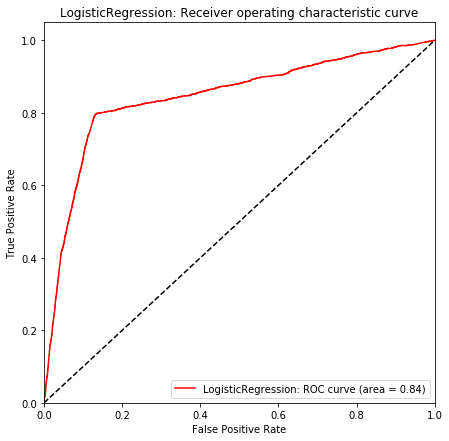

In [40]:
fpr, tpr, _ = roc_curve(y_valid, logreg_proba_1)
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "LogisticRegression", color='r')
print("LogisticRegression: AUC_ROC = %.3f" % auc(fpr, tpr))

Достаточно хороший показатель метркии ROC AUC

##### Precision-Recall-кривая

LogisticRegression: AUC_PR = 0.350


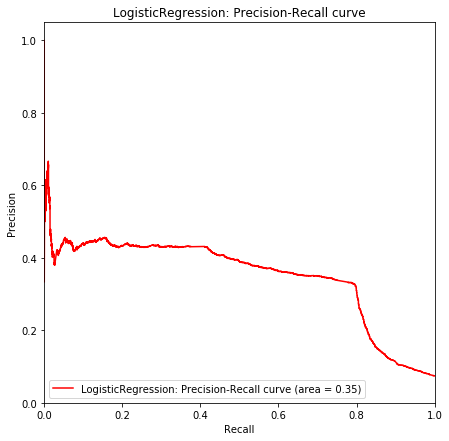

In [41]:
precision, recall, _ = precision_recall_curve(y_valid, logreg_proba_1)

plt.figure(figsize=(7, 7))    
plot_precision_recall_curve(precision, recall, "LogisticRegression", color='r')
print("LogisticRegression: AUC_PR = %.3f" % auc(recall, precision))

##### Матрица смежности

In [42]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[22078  3334]
 [  415  1618]]


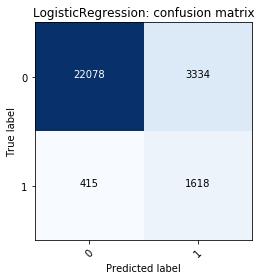

In [43]:
# TN                FP(Type II error)
# 
# FN(Type I error)  TP

cm = confusion_matrix(y_valid, logreg_pred > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="LogisticRegression");

Матрица смежности показывает

* в левом верхнем углу количество истинных предсказаний класса 0
* в правом верхнем углу количество ложных предсказаний класса 1 (ошибка второго рода)
* в левом нижнем углу количество ложных предсказаний класса 0 (ошибка первого рода)
* в правом нижнем углу количество истинных предсказаний класса 1

Если принять за нулевую гипотезу - положительный отклик клиента на услугу (класс 1), и осуществлять клиентам рассылку предложений по подключению услуги согласно предсказаниям модели, то

* количество ошибок первого рода характеризует сколько клиентов не получили предложения, хотя потенцаильно они готовы совершить подключение;
* количество ошибок второго рода характеризует сколько клиентов получили предложения, хотя они не собираются совершать подключение.

##### classification_report

In [44]:
# выбирем порог 0.5
print(classification_report(y_valid, logreg_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     25412
         1.0       0.33      0.80      0.46      2033

    accuracy                           0.86     27445
   macro avg       0.65      0.83      0.69     27445
weighted avg       0.93      0.86      0.89     27445



### 4. Библиотека Catboost¶

#### 4.1 Предобработка данных

Catboost не требует масштабировать числовые признаки и кодировать категориальные.

In [45]:
selector = SelectPercentile()
X_cat = selector.fit_transform(X[f_ok], y)
columns = X[f_ok].columns
support = selector.get_support()
selected_columns = columns[support]

for feat in f_categorical+f_weight:
    assert feat in selected_columns

X_cat = pd.DataFrame(X_cat, columns=selected_columns)

X_cat[f_categorical] = X_cat[f_categorical].astype('int').astype('category')

In [46]:
# Зафиксируем значение random_state для воспроизводимости результатов.
RANDOM_STATE = 42

X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = train_test_split(X_cat, y,
                                                                      train_size=0.1,
                                                                      test_size=0.033,
                                                                      random_state=RANDOM_STATE)

#### 4.2 Модель CatBoostClassifier

* Функция потерь: Logloss
* Автобалансировка классов

**Определение гиперпараметров**

Константные параметры:

- loss_function='Logloss' - показатель, используемый для обучения
- eval_metric='F1' - метрика, используемая для обнаружения переобучения
- auto_class_weights='Balanced' - автоматический подбор весов для балансировки классов
- random_seed или random_state – случайное зерно, используемое для обучения
- logging_level='Verbose' - вывод оптимизированных метрик, затраченного и оставшегося времени обучения
- task_type='GPU' – используется CPU или GPU. По умолчанию стоит CPU
- cat_features=f_categorical - массив с категориальными признаками
- one_hot_max_size=20 - максимальное количество уникальных значений среди категориальных признаков
- early_stopping_rounds=50 - отслеживание переобучения


Подбираемые параметры (сетка гиперпараметров):

- depth - глубина дерева
- learning_rate - скорость обучения
- iterations (n_estimators) - максимальное количество построенных деревьев
- l2_leaf_reg - коэффициент при члене регуляризации L2 функции потерь
- bagging_temperature - настройка интенсивности байесовского бутстрапа, по умолчанию=1

In [47]:
frozen_params = {
    'loss_function':'Logloss',
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'random_state': 42,
    'logging_level': 'Verbose',
    'task_type': 'GPU',
    'cat_features': f_categorical,
    'one_hot_max_size': 20,
    'early_stopping_rounds': 50,
}

In [48]:
%%time

cat_model = CatBoostClassifier(**frozen_params)

params_grid = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.03, 0.1, 0.3],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 5, 10, 20],
    'bagging_temperature': [1, 1.5, 2]
}

Wall time: 9.04 ms


##### Рандомизированный поиск по сетке с применением кросс-валидации

Случайным образом по сетке параметров выбирается и проверяется 30 наборов гиперпараметров.

In [49]:
%%time

search_result = cat_model.randomized_search(params_grid,
                                            X=X_train_cat,
                                            y=y_train_cat,
                                            cv=3,
                                            stratified=True,
                                            search_by_train_test_split=False,
                                            n_iter=30)

Stopped by overfitting detector  (50 iterations wait)
0:	loss: 0.8230655	best: 0.8230655 (0)	total: 30.1s	remaining: 14m 31s
Stopped by overfitting detector  (50 iterations wait)
1:	loss: 0.8230822	best: 0.8230822 (1)	total: 50.8s	remaining: 11m 50s
Stopped by overfitting detector  (50 iterations wait)
2:	loss: 0.8219707	best: 0.8230822 (1)	total: 1m 12s	remaining: 10m 49s
Stopped by overfitting detector  (50 iterations wait)
3:	loss: 0.8227360	best: 0.8230822 (1)	total: 1m 30s	remaining: 9m 50s
Stopped by overfitting detector  (50 iterations wait)
4:	loss: 0.8191445	best: 0.8230822 (1)	total: 2m 1s	remaining: 10m 6s
Stopped by overfitting detector  (50 iterations wait)
5:	loss: 0.8189858	best: 0.8230822 (1)	total: 2m 31s	remaining: 10m 5s
Stopped by overfitting detector  (50 iterations wait)
6:	loss: 0.8180760	best: 0.8230822 (1)	total: 3m 58s	remaining: 13m 3s
Stopped by overfitting detector  (50 iterations wait)
7:	loss: 0.8229543	best: 0.8230822 (1)	total: 4m 50s	remaining: 13m 20s

#### Параметры наилучшей модели

In [50]:
best_cat_params = search_result['params']
print("Лучшие гиперпараметры:")
pd.Series(best_cat_params)

Лучшие гиперпараметры:


bagging_temperature      1.00
depth                   10.00
l2_leaf_reg             20.00
iterations             500.00
learning_rate            0.03
dtype: float64

**Предсказание на валидационной выборке**

* вероятность класса 1
* метки

In [51]:
cat_proba_1 = cat_model.predict_proba(X_valid_cat)[:,1]
cat_pred = cat_model.predict(X_valid_cat)

#### 4.3 Анализ результатов предсказания

ROC-кривая

CatBoostClassifier: AUC_ROC = 0.853
LogisticRegression: AUC_ROC = 0.845


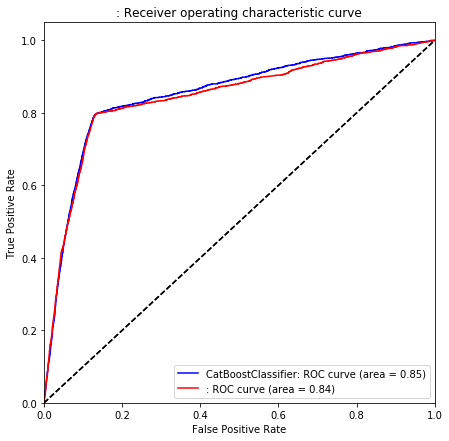

In [52]:
fpr, tpr, _ = roc_curve(y_valid_cat, cat_proba_1)
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "CatBoostClassifier", color='b')
print("CatBoostClassifier: AUC_ROC = %.3f" % auc(fpr, tpr))

fpr, tpr, _ = roc_curve(y_valid, logreg_proba_1)
plot_roc_curve(fpr, tpr, "", color='r')
print("LogisticRegression: AUC_ROC = %.3f" % auc(fpr, tpr))

Catboost имеет чуть лучший показатель.

##### Precision-Recall-кривая¶

CatBoostClassifier: AUC_PR = 0.350
LogisticRegression: AUC_PR = 0.350


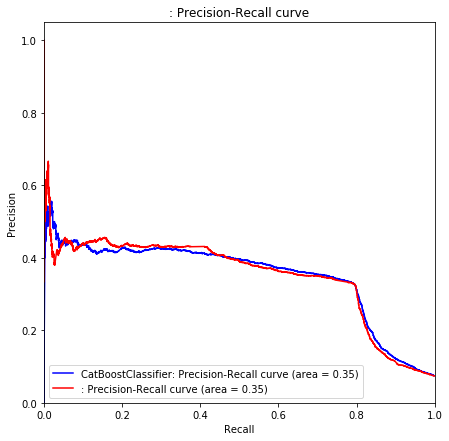

In [53]:
precision, recall, _ = precision_recall_curve(y_valid_cat, cat_proba_1)
plt.figure(figsize=(7, 7))    
plot_precision_recall_curve(precision, recall, "CatBoostClassifier", color='b')
print("CatBoostClassifier: AUC_PR = %.3f" % auc(recall, precision))

precision, recall, _ = precision_recall_curve(y_valid, logreg_proba_1) 
plot_precision_recall_curve(precision, recall, "", color='r')
print("LogisticRegression: AUC_PR = %.3f" % auc(recall, precision))

##### Матрица смежности

Confusion matrix, without normalization
[[22161  3251]
 [  428  1605]]


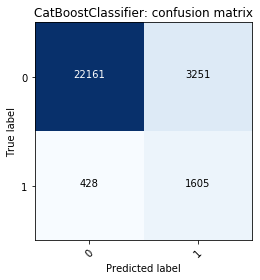

In [54]:
# print(confusion_matrix(y_valid,cat_pred))

# TN                FP(Type II error)
# 
# FN(Type I error)  TP

cm = confusion_matrix(y_valid_cat,cat_pred)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="CatBoostClassifier");

##### classification_report

In [55]:
print('LogisticRegression')
print(classification_report(y_valid, logreg_pred > 0.5))
print()
print('CatBoostClassifier')
print(classification_report(y_valid_cat,cat_pred))

LogisticRegression
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     25412
         1.0       0.33      0.80      0.46      2033

    accuracy                           0.86     27445
   macro avg       0.65      0.83      0.69     27445
weighted avg       0.93      0.86      0.89     27445


CatBoostClassifier
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     25412
         1.0       0.33      0.79      0.47      2033

    accuracy                           0.87     27445
   macro avg       0.66      0.83      0.69     27445
weighted avg       0.93      0.87      0.89     27445



Catboost имеет чуть лучший показатель F1

#### 4.4 Применение результата

При построении стратегии рассылки предложений необходимо учитывать следующее.

Прибыль оператора от положительного отклика клиента на услугу равна разнице Дохода от клиента и Затрат на рассылку предложения клиенту.

$$Прибыль = Доход - Затраты $$

Ошибка первого рода отражает доход, который оператор потерял, не отправив предложение. Ошибка второго рода отражает затраты оператора на рассылку предложения клиенту, которые оказались напрасными.

Итого реальная прибыль от кампании по рассылке предложений будет определяться формулой:

$$REAL = N_+ \cdot (Доход - Затраты) - N_{e2} \cdot Затраты$$
,

а упущенная прибыль

$$N_{e1} \cdot (Доход - Затраты)$$
,

максимально возможная прибыль определяется формулой:

$$MAX = (N_+ + N_{e1}) \cdot (Доход - Затраты)$$
где $N_+$ - количество положительных откликов на отправленное предложение

$N_{e1}$ - количество упущенных клиентов, готовых подключить услугу (ош. 1 рода)

$N_{e2}$ - количество напрастно отправленных предложений (ош. 2 рода)

Для получения максимальной выгоды необходимо минимизировать разницу $MAX - REAL$, то есть упрощая выражение

$$\frac{Доход - Затраты}{Затраты} \cdot N_{e1} + N_{e2} \rightarrow min$$
Так как Доход от подключения услуги, как правило, на несколько порядков превышает Затрату на рассылку предложения (например, услуга со стоимостью подключения 100 р., затрата на смс-рассылку 10 коп.), то $N_{e1}$ гораздо сильнее влияет, чем $N_{e2}$, на изменение выгоды. Максимально возможная выгода достигается лишь, когда $N_{e1}=N_{e2}=0$, то есть оператор абсолютно безошибочно разослал все предложения. Это практически невозможно и является идеальным случаем.

***Построим график количества ошибок 1 и 2 рода при разных порогах на предсказаниях модели***

Используя последнюю формулу и задавая конкретные значения Дохода income от услуги и Затрат expense на предложение найдем порог, при котором мы добъемся максимальной выгоды

In [56]:
def plot_fp_fn_curve(y_true, y_pred_proba, threshold, income_expense):
    
    plt.figure(figsize=(10, 5))  
    
    fp_fn_thr = list()
    for thr in threshold:
        y_pred = np.ones(y_pred_proba.shape)
        y_pred[y_pred_proba<thr] = 0
        fp, fn = confusion_matrix(y_true, y_pred).ravel()[1:3]
        fp_fn_thr.append([fp, fn, thr])
        
    vectors = np.array(fp_fn_thr)[:,0:2]
    thresholds = np.array(fp_fn_thr)[:,2]
    plt.plot(vectors[:,0], vectors[:,1], c='black', label='model FP-FN-curve', alpha=0.5)
    
    for income, expense in income_expense:
        coef = income / expense - 1
        ie_vectors = vectors.copy()
        ie_vectors[:,1] = ie_vectors[:,1] * coef        
        norms = np.linalg.norm(ie_vectors, axis=1)
        min_idx = np.where(norms == np.amin(norms))
        plt.scatter(vectors[min_idx,0],
                    vectors[min_idx,1],                   
                    label=f'income:{income}, expense:{expense}, threshold:{thresholds[min_idx][0]:.2f}')
    
    plt.legend(loc="upper right")
    plt.xlabel('False Positive')
    plt.ylabel('False Negative')
    plt.show()

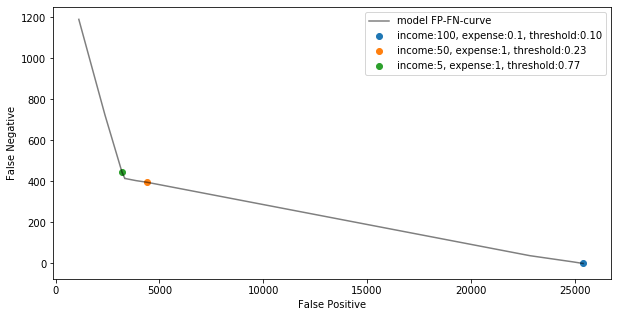

In [57]:
income_expense = [[100, 0.1],
                  [50, 1],
                  [5, 1]]

plot_fp_fn_curve(y_valid, logreg_proba_1, np.linspace(0.1,0.9,20), income_expense)

* доход 100 р., затраты 10 коп. - наиболее оптимальный порог для предсказаний с максимальной выгодой - 0.10
* доход 50 р., затраты 1 руб. - наиболее оптимальный порог для предсказаний с максимальной выгодой - 0.23
* доход 5 р., затраты 1 руб. - наиболее оптимальный порог для предсказаний с максимальной выгодой - 0.77

### 5 Финальная модель и предсказание на тестовых данных

#### Предобработка и селекция полной тренировочной выборки

In [58]:
selector = SelectPercentile()
X_cat_fin = selector.fit_transform(X[f_ok], y)
columns = X[f_ok].columns
support = selector.get_support()
selected_columns = columns[support]

for feat in f_categorical+f_weight:
    assert feat in selected_columns

X_cat_fin = pd.DataFrame(X_cat_fin, columns=selected_columns)

X_cat_fin[f_categorical] = X_cat_fin[f_categorical].astype('int').astype('category')

#### Обучение финальной модели Catboost

Лучшие гиперпараметры:
- bagging_temperature      2.00
- depth                   10.00
- l2_leaf_reg             20.00
- iterations             100.00
- learning_rate            0.03

In [59]:
fin_model = CatBoostClassifier(**frozen_params,
                               **best_cat_params)

In [60]:
fin_model.fit(X=X_cat_fin, y=y)

0:	learn: 0.8215023	total: 123ms	remaining: 1m 1s
1:	learn: 0.8216760	total: 229ms	remaining: 57s
2:	learn: 0.8216550	total: 337ms	remaining: 55.8s
3:	learn: 0.8216578	total: 445ms	remaining: 55.2s
4:	learn: 0.8216755	total: 552ms	remaining: 54.6s
5:	learn: 0.8216664	total: 656ms	remaining: 54s
6:	learn: 0.8216738	total: 754ms	remaining: 53.1s
7:	learn: 0.8216648	total: 853ms	remaining: 52.5s
8:	learn: 0.8216670	total: 960ms	remaining: 52.4s
9:	learn: 0.8216788	total: 1.06s	remaining: 51.9s
10:	learn: 0.8216766	total: 1.15s	remaining: 51.1s
11:	learn: 0.8216648	total: 1.25s	remaining: 50.8s
12:	learn: 0.8216636	total: 1.35s	remaining: 50.6s
13:	learn: 0.8216670	total: 1.45s	remaining: 50.4s
14:	learn: 0.8216592	total: 1.55s	remaining: 50.2s
15:	learn: 0.8216633	total: 1.66s	remaining: 50.1s
16:	learn: 0.8216605	total: 1.76s	remaining: 50s
17:	learn: 0.8216583	total: 1.86s	remaining: 50s
18:	learn: 0.8216600	total: 1.97s	remaining: 49.9s
19:	learn: 0.8216533	total: 2.07s	remaining: 49.7

161:	learn: 0.8216897	total: 16.8s	remaining: 35.1s
162:	learn: 0.8216908	total: 17s	remaining: 35s
163:	learn: 0.8216913	total: 17.1s	remaining: 35s
164:	learn: 0.8216930	total: 17.2s	remaining: 34.9s
165:	learn: 0.8216930	total: 17.3s	remaining: 34.7s
166:	learn: 0.8216930	total: 17.4s	remaining: 34.7s
167:	learn: 0.8216930	total: 17.5s	remaining: 34.6s
168:	learn: 0.8216936	total: 17.6s	remaining: 34.5s
169:	learn: 0.8216936	total: 17.7s	remaining: 34.4s
170:	learn: 0.8216936	total: 17.8s	remaining: 34.3s
171:	learn: 0.8216936	total: 17.9s	remaining: 34.2s
172:	learn: 0.8216936	total: 18s	remaining: 34.1s
173:	learn: 0.8216936	total: 18.1s	remaining: 34s
174:	learn: 0.8216941	total: 18.2s	remaining: 33.9s
175:	learn: 0.8216941	total: 18.3s	remaining: 33.8s
176:	learn: 0.8216941	total: 18.5s	remaining: 33.7s
177:	learn: 0.8216936	total: 18.6s	remaining: 33.6s
178:	learn: 0.8217038	total: 18.7s	remaining: 33.5s
179:	learn: 0.8217038	total: 18.8s	remaining: 33.4s
180:	learn: 0.8217162	

321:	learn: 0.8224562	total: 34.1s	remaining: 18.9s
322:	learn: 0.8224867	total: 34.2s	remaining: 18.7s
323:	learn: 0.8224663	total: 34.3s	remaining: 18.6s
324:	learn: 0.8224760	total: 34.4s	remaining: 18.5s
325:	learn: 0.8224658	total: 34.6s	remaining: 18.4s
326:	learn: 0.8224873	total: 34.7s	remaining: 18.3s
327:	learn: 0.8224867	total: 34.8s	remaining: 18.2s
328:	learn: 0.8225184	total: 34.9s	remaining: 18.1s
329:	learn: 0.8225076	total: 35s	remaining: 18s
330:	learn: 0.8225178	total: 35.1s	remaining: 17.9s
331:	learn: 0.8225382	total: 35.2s	remaining: 17.8s
332:	learn: 0.8225484	total: 35.3s	remaining: 17.7s
333:	learn: 0.8225699	total: 35.5s	remaining: 17.6s
334:	learn: 0.8225704	total: 35.6s	remaining: 17.5s
335:	learn: 0.8225908	total: 35.7s	remaining: 17.4s
336:	learn: 0.8226213	total: 35.8s	remaining: 17.3s
337:	learn: 0.8226208	total: 35.9s	remaining: 17.2s
338:	learn: 0.8226213	total: 36s	remaining: 17.1s
339:	learn: 0.8226315	total: 36.1s	remaining: 17s
340:	learn: 0.822641

481:	learn: 0.8242024	total: 52.1s	remaining: 1.95s
482:	learn: 0.8242131	total: 52.2s	remaining: 1.84s
483:	learn: 0.8242115	total: 52.3s	remaining: 1.73s
484:	learn: 0.8242222	total: 52.5s	remaining: 1.62s
485:	learn: 0.8242335	total: 52.6s	remaining: 1.51s
486:	learn: 0.8242436	total: 52.7s	remaining: 1.41s
487:	learn: 0.8242938	total: 52.8s	remaining: 1.3s
488:	learn: 0.8243029	total: 52.9s	remaining: 1.19s
489:	learn: 0.8243243	total: 53s	remaining: 1.08s
490:	learn: 0.8243130	total: 53.1s	remaining: 973ms
491:	learn: 0.8243429	total: 53.2s	remaining: 865ms
492:	learn: 0.8243632	total: 53.3s	remaining: 757ms
493:	learn: 0.8243728	total: 53.4s	remaining: 649ms
494:	learn: 0.8243531	total: 53.6s	remaining: 541ms
495:	learn: 0.8243745	total: 53.7s	remaining: 433ms
496:	learn: 0.8243835	total: 53.8s	remaining: 325ms
497:	learn: 0.8243931	total: 53.9s	remaining: 216ms
498:	learn: 0.8244338	total: 54s	remaining: 108ms
499:	learn: 0.8244546	total: 54.1s	remaining: 0us


сохранение финальной модели в pickle

In [73]:
import pickle
with open('final_model.pkl', 'wb') as file:
        pickle.dump(fin_model, file)

### Прогнозирование на тестовом датасете

#### Загрузка, предобработка и селекция тестовых данных

In [66]:
test_df = pd.read_pickle(test_path)

In [67]:
w_sc = StandardScaler().fit_transform(test_df['time_delta'].values.reshape(-1,1))
w = 1 / (1 + np.exp(w_sc))

assert not np.isnan(w).any()

test_df['time_delta'] = w

X_test = test_df.drop(['id','buy_time_vas'], axis=1)

X_test.loc[X_test['252']>1,:] = X_test['252'].value_counts().argmax()

X_cat_test = selector.transform(X_test[f_ok])

X_cat_test = pd.DataFrame(X_cat_test, columns=selected_columns)

X_cat_test[f_categorical] = X_cat_test[f_categorical].astype('int').astype('category')

#### Предсказание на тестовых данных

In [68]:
test_pred_proba = fin_model.predict_proba(X_cat_test)[:,1]

#### Формирование отчетного файла с предсказаниями и его сохранение в answers_test.csv

In [69]:
answers_test = test_df[['buy_time_vas', 'id', 'vas_id']].rename(columns={'buy_time_vas': 'buy_time'}).copy()

In [70]:
answers_test['target'] = test_pred_proba

In [71]:
answers_test.head()

,buy_time,id,vas_id,target
0,1.548018e+09,3130519.0,2.0,0.178671
1,1.548018e+09,2000860.0,4.0,0.751763
2,1.546808e+09,1099444.0,2.0,0.260089
3,1.547413e+09,1343255.0,5.0,0.197558
4,1.546808e+09,1277040.0,2.0,0.199785


In [74]:
answers_test.to_csv('answers_test.csv')